In [32]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Astropy imports
from astropy.table import Table

# Lenstronomy, HierArc imports
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from likelihoods_parallel import beta2theta_e_ratio, beta_double_source_plane

# set global plotting parameters for academic paper
# plt.rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
#     "legend.fontsize": 12,
#     "figure.titlesize": 16,
#     "figure.figsize": (8, 6),
#     "lines.linewidth": 1.5,
#     "lines.markersize": 6,
#     "font.family": "serif",
#     "text.usetex": True,
# })

# Fit plane to the data
def fit_plane(x, y, z):
    """Fit a plane to the data points (x, y, z). The plane is z = ax + by + c."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    A = np.c_[x, y, np.ones_like(x)]
    coeffs, _, _, _ = np.linalg.lstsq(A, z, rcond=None)
    return coeffs

# Find the scatter of the data points from the fitted plane
def find_scatter(x, y, z, coeffs, return_fit=False):
    """Find the scatter of the data points from the fitted plane. Return ``z - z_fit``."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    z_fit = coeffs[0] * x + coeffs[1] * y + coeffs[2]
    scatter = z - z_fit
    if return_fit:
        return scatter, z_fit
    else:
        return scatter

In [98]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "30.0v2"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.874766281062172,3.545583064828747,0.5271512655623897,260.5978887361845,26.853258195825937,26.925494458520753,27.457930599662895,26.686583709588596,26.544720166139122,25.92318926265024,26.507824702469186,26.905931674721835,24.595022342638423,23.93346948236516,0.5797774619756767,-0.002208108153086985,0.005392911277923769,0.005827455162185858,2,4.8826461669528705,6542.855098668025,28.158590719935617
1,0.4138050696952206,3.8343999994409157,1.4393258840689025,254.05329891410793,25.64551209236478,25.688530776877375,26.278716081794247,25.491088026004245,25.417914573833546,18.520716732657142,19.171248409828237,20.74093773475746,18.179217256496216,17.989868312429635,1.247678057249737,0.006132279192749697,0.046362948498560715,0.0467667386245612,2,6.842377061519371,3383.0904062076133,23.684399870902915
2,0.32325614833622546,1.263051255692255,0.7821164871523214,200.91758583641038,23.05913286966915,23.16094579234929,23.143077146533578,22.772195739206346,22.501368399948653,18.476642206325824,19.031728576226843,20.415057196143994,18.15740576610015,17.96729603646998,0.8853398414803644,-0.02204878885825497,-0.12385023078879108,0.12579757055107513,2,4.14959152859635,2424.2058253119626,22.612022305783967
3,0.562141659276947,2.228935373955962,0.6268352573021465,187.2509190836209,26.32172970675993,26.391798005724706,26.51507877033796,26.23047250398506,26.044465790413806,20.465941368751388,21.458442825869838,22.872098464130787,20.076895394594914,19.83176447679721,0.3718393435641739,-0.23364958536235933,0.01565812010614346,0.23417366518304497,2,2.409915827920992,3088.000865920878,23.161506725191224
4,0.32961696763102005,1.8364011969163303,1.1746055885230164,235.226967710898,27.08233854845476,27.275334657725264,27.535833391621477,26.800717489346663,26.679558011978283,17.96329993252079,18.4787842754518,19.81192721189381,17.655825334177578,17.495461785609464,0.8975541164216171,-0.06691971811502932,-0.157046084220501,0.1707094644171426,2,4.2620605583452384,3160.3052913670053,22.013002413861788
5,1.1885315447926554,3.1073255592617306,0.5777091801342814,218.13052859942349,25.359687854320633,25.458911457336384,25.55357438747121,25.274512613609943,25.316853240155538,22.838022047453812,23.28921679526814,23.44175965607225,22.29643928459837,21.75708160588045,0.3852627009757341,0.07560748726390835,0.17197368728797346,0.18786016408430967,2,3.190597556438011,7201.423349682187,23.82337151452748
6,1.2440370141998318,3.760970123815943,0.8460494611952895,255.67390161839958,26.605306337160417,26.634371681949826,27.14991616134917,26.44767661651716,26.356053550173673,22.961834070119288,23.95417983437018,24.56918427670501,22.245718878420327,21.531031936475514,0.6906795913465504,0.0037815838235121923,-0.0018989305919526673,0.004231585235736461,2,5.75659122289918,5888.682565311953,26.213378895096472
7,1.2186608418866445,2.9173020967013943,0.7909399459500751,263.88597471954085,25.951824495289113,26.174535381052156,26.385565314046598,25.800195257663386,25.734022059756608,23.074782975496294,24.46612036927917,26.09137599472469,22.299809513418207,21.50800078275739,0.5735765385699269,0.06977142660841433,-0.06394371013497493,0.0946406362869515,2,4.76742377834762,6574.3099157719225,27.312897074985525
8,1.3205838348704433,3.3341757883448344,0.5647478195163559,222.16083231572213,25.194104702779097,25.34107204741434,25.727573876422294,25.047481342231574,24.93893135962986,23.698905530774027,24.50735038605537,24.7385994037762,23.179622169600314,22.403521342179367,0.4016907793891605,0.1275790419352308,0.16584650412686347,0.209240232441596,2,3.370733889796594,5373.308523883364,25.15147809628904


In [99]:
# fit the MFP
coeffs_MFP = fit_plane(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"])
)

# find the scatter
scatter_MFP = find_scatter(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"]),
    coeffs_MFP,
    return_fit=False
)

coeffs_MFP_alt = fit_plane(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
)

scatter_MFP_alt = find_scatter(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
    coeffs_MFP_alt,
    return_fit=False
)

In [100]:
# make bins on the R_e vs Sigma_half plane and make pairings
# then compute the scatter in sigma_v_D from pairings
# and also the scatter in beta_E from pairings

num_bins = 20  # number of bins


# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# binned statistics
binned_statistics = {
    'rel_scatter_beta_E': np.ones((num_bins - 1, num_bins - 1))*np.nan,
    'rel_scatter_sigma_v_D': np.ones((num_bins - 1, num_bins - 1))*np.nan,
}
THRESHOLD_DELTA_Z = 0.01  # threshold for delta_z to consider a pair valid

# store pairing data template 
individual_pair_data = {
    'beta_E_pseudo': [],
    'beta_E_DSPL': [],
    'z_D1': [],
    'z_D2': [],
    'z_S1': [],
    'z_S2': [],
    'sigma_v_D1': [],
    'sigma_v_D2': [],
    'lens1_id': [],
    'lens2_id': [],
}

# make bins on the R_e vs Sigma_half plane
x = np.log10(GGL_data_table["R_e_kpc"])
y = np.log10(GGL_data_table["Sigma_half_Msun/pc2"])

x_bins = np.linspace(np.nanmin(x), np.nanmax(x), num_bins)
y_bins = np.linspace(np.nanmin(y), np.nanmax(y), num_bins)

# make pairings
for i in tqdm(range(len(x_bins) - 1)):
    for j in range(len(y_bins) - 1):
        mask = (
            (x >= x_bins[i]) & (x < x_bins[i + 1]) &
            (y >= y_bins[j]) & (y < y_bins[j + 1])
        )
        if np.sum(mask) < 2:
            continue
        
        # get the data points in this bin
        data_points = GGL_data_table[mask]
        
        curr_bin_sig_v_D1s = []
        curr_bin_sig_v_D2s = []
        curr_bin_beta_E_pseudos = []
        curr_bin_beta_E_DSPLs = []


        # make pairings
        for lens1, lens2 in combinations(data_points, 2):
            beta_E_pseudo = lens1['theta_E'] / lens2['theta_E']

            # check z_lens < z_source
            if lens1['z_D'] >= lens2['z_S'] or lens2['z_D'] >= lens1['z_S']:
                continue

            beta_DSPL = beta_double_source_plane(
                z_lens = np.mean([lens1['z_D'], lens2['z_D']]),
                z_source_1= lens1['z_S'],
                z_source_2= lens2['z_S'],
                cosmo = cosmo_true,
            )
            beta_E_DSPL = beta2theta_e_ratio(
                beta_dsp= beta_DSPL,
                gamma_pl= 2, #TODO: what if gamma_pl != 2?
                lambda_mst= 1
            )

            individual_pair_data['beta_E_pseudo'].append(beta_E_pseudo)
            individual_pair_data['beta_E_DSPL'].append(beta_E_DSPL)
            individual_pair_data['z_D1'].append(lens1['z_D'])
            individual_pair_data['z_D2'].append(lens2['z_D'])
            individual_pair_data['z_S1'].append(lens1['z_S'])
            individual_pair_data['z_S2'].append(lens2['z_S'])
            individual_pair_data['sigma_v_D1'].append(lens1['sigma_v_D'])
            individual_pair_data['sigma_v_D2'].append(lens2['sigma_v_D'])
            individual_pair_data['lens1_id'].append(lens1['lens_id'])
            individual_pair_data['lens2_id'].append(lens2['lens_id'])

            if np.abs(lens1['z_D'] - lens2['z_D']) <= THRESHOLD_DELTA_Z:
                curr_bin_sig_v_D1s.append(lens1['sigma_v_D'])
                curr_bin_sig_v_D2s.append(lens2['sigma_v_D'])
                curr_bin_beta_E_pseudos.append(beta_E_pseudo)
                curr_bin_beta_E_DSPLs.append(beta_E_DSPL)
        
        # make numpy arrays
        curr_bin_sig_v_D1s = np.array(curr_bin_sig_v_D1s)
        curr_bin_sig_v_D2s = np.array(curr_bin_sig_v_D2s)
        curr_bin_beta_E_pseudos = np.array(curr_bin_beta_E_pseudos)
        curr_bin_beta_E_DSPLs = np.array(curr_bin_beta_E_DSPLs)

        # compute the relative scatter in beta_E and sigma_v_D
        if len(curr_bin_sig_v_D1s) > 0 and len(curr_bin_sig_v_D2s) > 0:
            # relative scatter in beta_E
            rel_scatter_beta_E = np.std(1 - curr_bin_beta_E_pseudos/curr_bin_beta_E_DSPLs)
            binned_statistics['rel_scatter_beta_E'][i, j] = rel_scatter_beta_E

            # relative scatter in sigma_v_D
            rel_scatter_sigma_v_D = 2 * np.std(curr_bin_sig_v_D1s - curr_bin_sig_v_D2s)/ np.mean(curr_bin_sig_v_D1s + curr_bin_sig_v_D2s)
            binned_statistics['rel_scatter_sigma_v_D'][i, j] = rel_scatter_sigma_v_D

# convert to astropy tables
individual_pair_data_table = Table(individual_pair_data)

individual_pair_data_table

100%|██████████| 19/19 [00:04<00:00,  4.05it/s]


beta_E_pseudo,beta_E_DSPL,z_D1,z_D2,z_S1,z_S2,sigma_v_D1,sigma_v_D2,lens1_id,lens2_id
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
0.996687189703584,0.9190369046032618,0.28638287313515565,0.5490475117561777,2.1378009847145996,3.4574050668379663,160.50218716488547,170.80317643792029,203,1076
1.1914060565859819,0.9715393479486535,0.46124080201635687,0.41875217738318377,3.063077054952251,3.7474680123603483,169.81280646799698,151.14997965558476,210,1416
0.9920058790199101,0.9916563034714317,0.34388023668865925,0.49465886905253836,3.2150112479990827,3.4157768873749528,149.87872507278152,157.77063162787056,1614,2022
0.8660709288600821,1.0100832478520398,0.19306452219856726,0.08387937609988712,1.781080096538311,1.5818901656669138,156.082266414136,159.81303547345087,698,1396
1.1186008782610806,0.9167277063067049,0.19306452219856726,0.46629667085623133,1.781080096538311,3.0876600887484944,156.082266414136,158.6843258442333,698,2659
0.9666053953560716,0.9809599259983255,0.19306452219856726,0.09627600747748878,1.781080096538311,2.328500623308244,156.082266414136,150.75519774243153,698,2768
1.2915811407425681,0.9117913513283831,0.08387937609988712,0.46629667085623133,1.5818901656669138,3.0876600887484944,159.81303547345087,158.6843258442333,1396,2659
1.1160811004571096,0.9822856912400596,0.08387937609988712,0.09627600747748878,1.5818901656669138,2.328500623308244,159.81303547345087,150.75519774243153,1396,2768
0.8641200039630818,1.0317875961302507,0.46629667085623133,0.09627600747748878,3.0876600887484944,2.328500623308244,158.6843258442333,150.75519774243153,2659,2768


In [101]:
# print the scatter in sigma_v_D for pairs with |z_D1 - z_D2| < 0.01
print(f"================= Sky Area: {sky_area} sq. deg. =================")
mask = np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) < 0.01
print(f"# of pairs with |z_D1 - z_D2| < 0.01: {np.sum(mask)}")
sigma_v_scatter = np.std(individual_pair_data_table[mask]['sigma_v_D1'] - individual_pair_data_table[mask]['sigma_v_D2']) / (np.mean(individual_pair_data_table[mask]['sigma_v_D1'] + individual_pair_data_table[mask]['sigma_v_D2']) / 2)
print(f"Relative scatter in σᵥ: {sigma_v_scatter:.3f}")

# scatter in beta_E
beta_E_scatter = np.std(1 - individual_pair_data_table[mask]['beta_E_pseudo']/individual_pair_data_table[mask]['beta_E_DSPL'])
print(f"Relative scatter in β_E: {beta_E_scatter:.3f}")
print()  # for better readability

================= Sky Area: 30.0v2 sq. deg. =================
# of pairs with |z_D1 - z_D2| < 0.01: 1401
Relative scatter in σᵥ: 0.084
Relative scatter in β_E: 0.176



## Plots for Paper

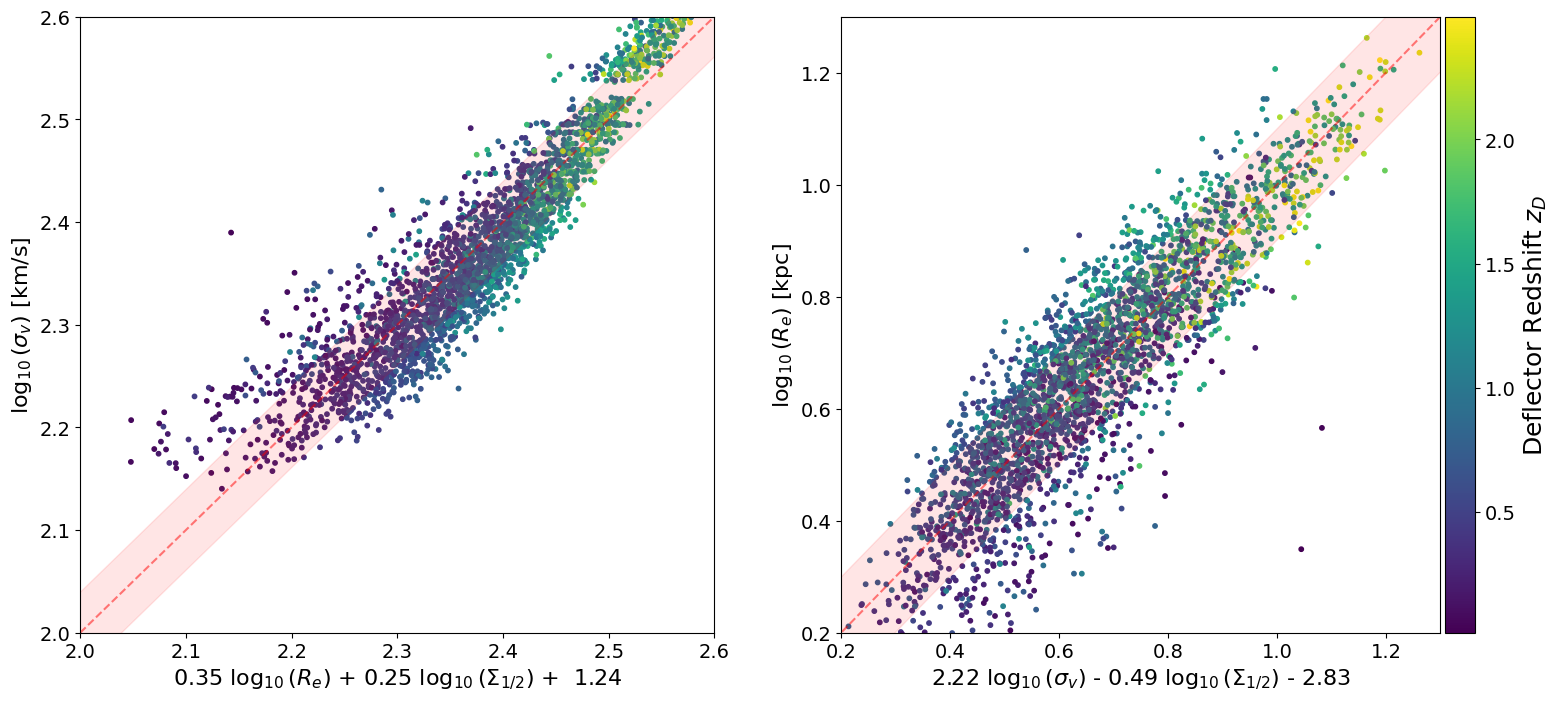

In [102]:
## MFP plot

# side-by-side plot of the two fundamental planes
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# sigma_v fundamental plane
axs[0].scatter(
    coeffs_MFP[0] * np.log10(GGL_data_table["R_e_kpc"]) + 
    coeffs_MFP[1] * np.log10(GGL_data_table["Sigma_half_Msun/pc2"]) + 
    coeffs_MFP[2],
    np.log10(GGL_data_table["sigma_v_D"]),
    c=GGL_data_table["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
axs[0].set_ylabel(r'$\log_{10}(\sigma_v)$ [km/s]')
# axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

# Plot the fitted plane with a faded scatter
# y = x
axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
            [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
            color='red', linestyle='--', alpha=0.5, label='y = x')
# faded region for the scatter
x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
y_faded = x_faded
axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                    y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

# R_e fundamental plane
scatter_plot = axs[1].scatter(
    coeffs_MFP_alt[0] * np.log10(GGL_data_table["sigma_v_D"]) + 
    coeffs_MFP_alt[1] * np.log10(GGL_data_table["Sigma_half_Msun/pc2"]) + 
    coeffs_MFP_alt[2],
    np.log10(GGL_data_table["R_e_kpc"]),
    c=GGL_data_table["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_v)$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
# axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
# Plot the fitted plane with a faded scatter
# y = x
axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
            [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
            color='red', linestyle='--', alpha=0.5, label='y = x')
# faded region for the scatter
x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
y_faded = x_faded
axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                    y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

# common colorbar
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(scatter_plot, cax=cax)
cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


# increase the font size of the labels and title
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=18)
    # ax.legend(fontsize=14)

cbar.ax.tick_params(labelsize=14)  # Colorbar tick labels

# cbar label size
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=18)

axs[0].set_xlim(2, 2.6)
axs[0].set_ylim(2, 2.6)
axs[1].set_xlim(0.2, 1.3)
axs[1].set_ylim(0.2, 1.3)

# save the figure
fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

Correlation Coefficient: 0.99, Slope: 2.07, Intercept: 0.00, Standard Error: 0.03

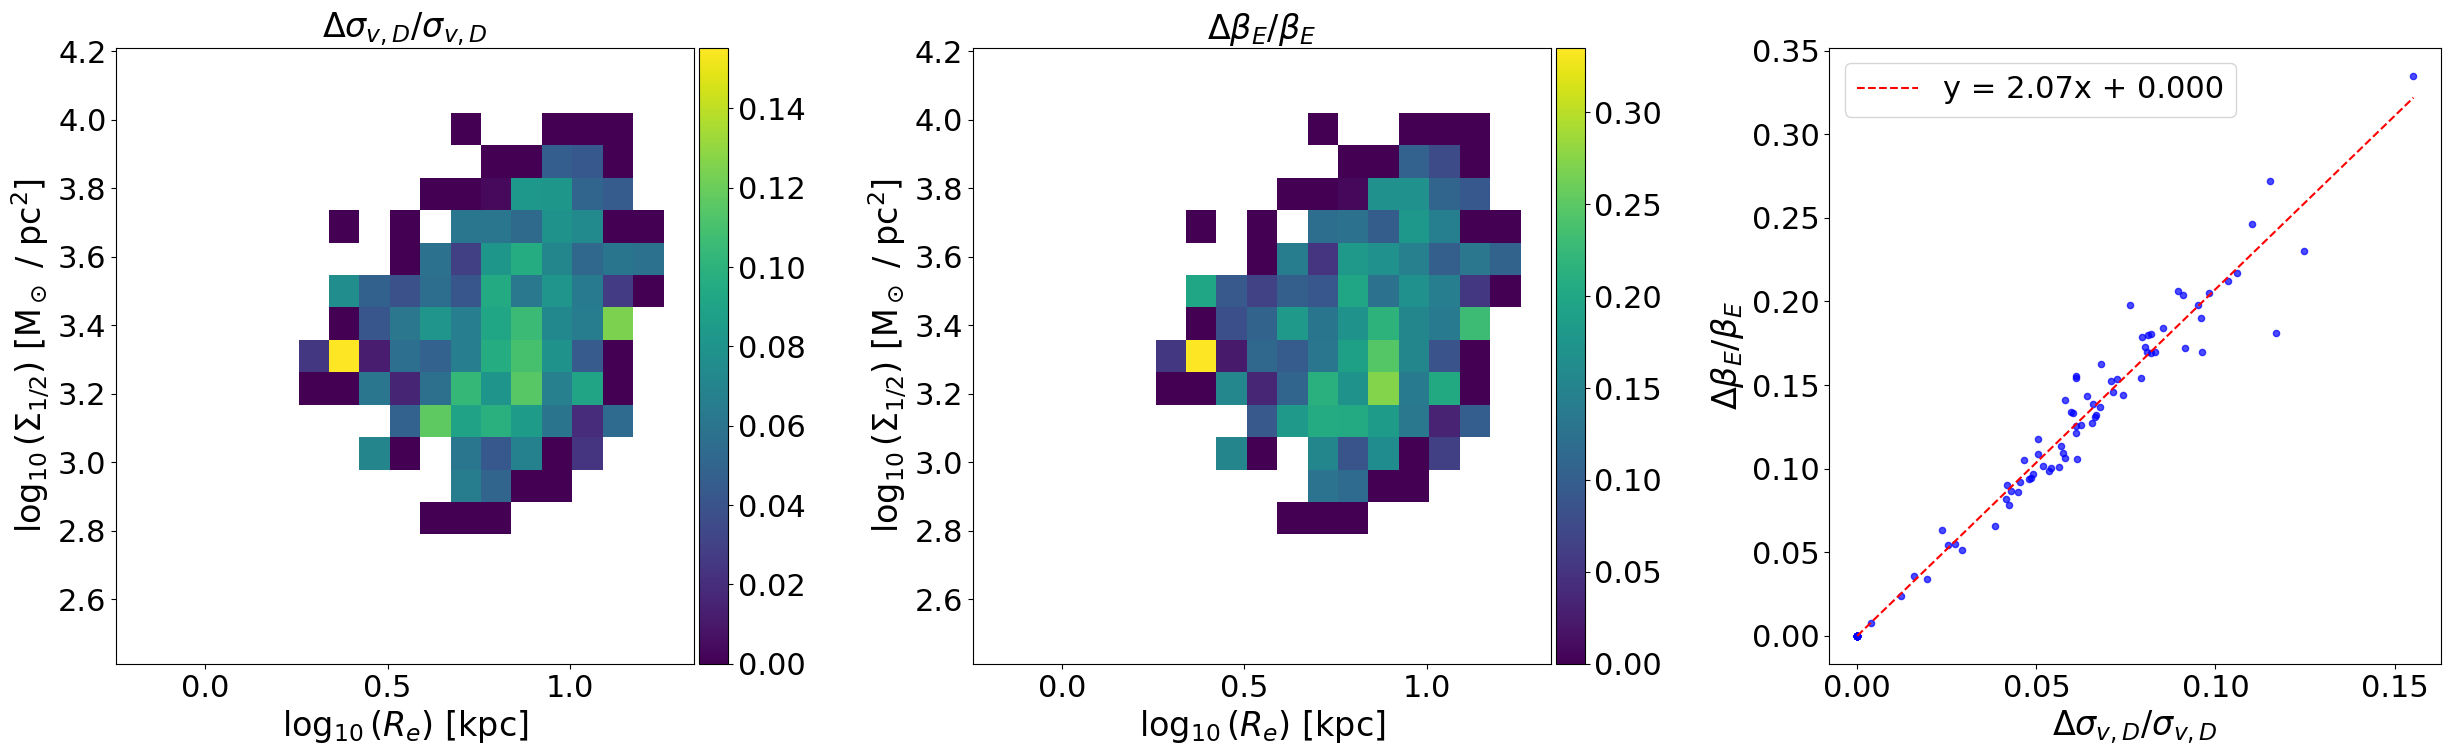

In [103]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(30, 8))

base_fontsize = 22

x_label = r'$\log_{10}(R_e)$ [kpc]'
y_label = r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$ / pc$^2$]'

# First plot: binned_statistics['rel_scatter_sigma_v_D']
im1 = axs[0].imshow(binned_statistics['rel_scatter_sigma_v_D'], origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[0].set_xlabel(x_label)
axs[0].set_ylabel(y_label)
axs[0].set_title(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=base_fontsize+2)

# Second plot: binned_statistics['rel_scatter_beta_E']
im2 = axs[1].imshow(binned_statistics['rel_scatter_beta_E'], origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[1].set_xlabel(x_label)
axs[1].set_ylabel(y_label)
axs[1].set_title(r'${\Delta \beta_E}/{\beta_E}$', fontsize=base_fontsize+2)

# Third plot: scatter plot between the two quantities
axs[2].scatter(binned_statistics['rel_scatter_sigma_v_D'].flatten(),
    binned_statistics['rel_scatter_beta_E'].flatten(),
    s=20, alpha=0.7, c='blue')
axs[2].set_xlabel(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=20)
axs[2].set_ylabel(r'${\Delta \beta_E}/{\beta_E}$', fontsize=20)

# Fit and plot line for the scatter plot
x_scatter = binned_statistics['rel_scatter_sigma_v_D'].flatten()
y_scatter = binned_statistics['rel_scatter_beta_E'].flatten()
mask = ~np.isnan(x_scatter) & ~np.isnan(y_scatter)
x_scatter = x_scatter[mask]
y_scatter = y_scatter[mask]
coeffs = np.polyfit(x_scatter, y_scatter, 1)
x_fit = np.linspace(np.nanmin(x_scatter), np.nanmax(x_scatter), 100)
y_fit = coeffs[0] * x_fit + coeffs[1]
axs[2].plot(x_fit, y_fit, color='red', linestyle='--', 
  label=f'y = {coeffs[0]:.2f}x + {coeffs[1]:.3f}')
axs[2].legend(fontsize=base_fontsize)

# Create separate axes for colorbars that take up the extra space

# Create colorbars with larger size to take up extra space
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

# Apply consistent styling
for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
  ax.set_xlabel(ax.get_xlabel(), fontsize=base_fontsize+2)
  ax.set_ylabel(ax.get_ylabel(), fontsize=base_fontsize+2)
  ax.set_title(ax.get_title(), fontsize=base_fontsize+2)

# Style colorbars
cbar1.ax.tick_params(labelsize=base_fontsize)
cbar2.ax.tick_params(labelsize=base_fontsize)

# Adjust the subplot widths to make them similar
plt.subplots_adjust(wspace=0.4)

# Save the figure
fig.savefig(f"../figures/slsim_scatter_rel_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)

# Correlation Coefficient and Scatter in Linear Regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    x_scatter, y_scatter
)
display(Markdown(f"Correlation Coefficient: {r_value:.2f}, Slope: {slope:.2f}, Intercept: {intercept:.2f}, Standard Error: {std_err:.2f}"))


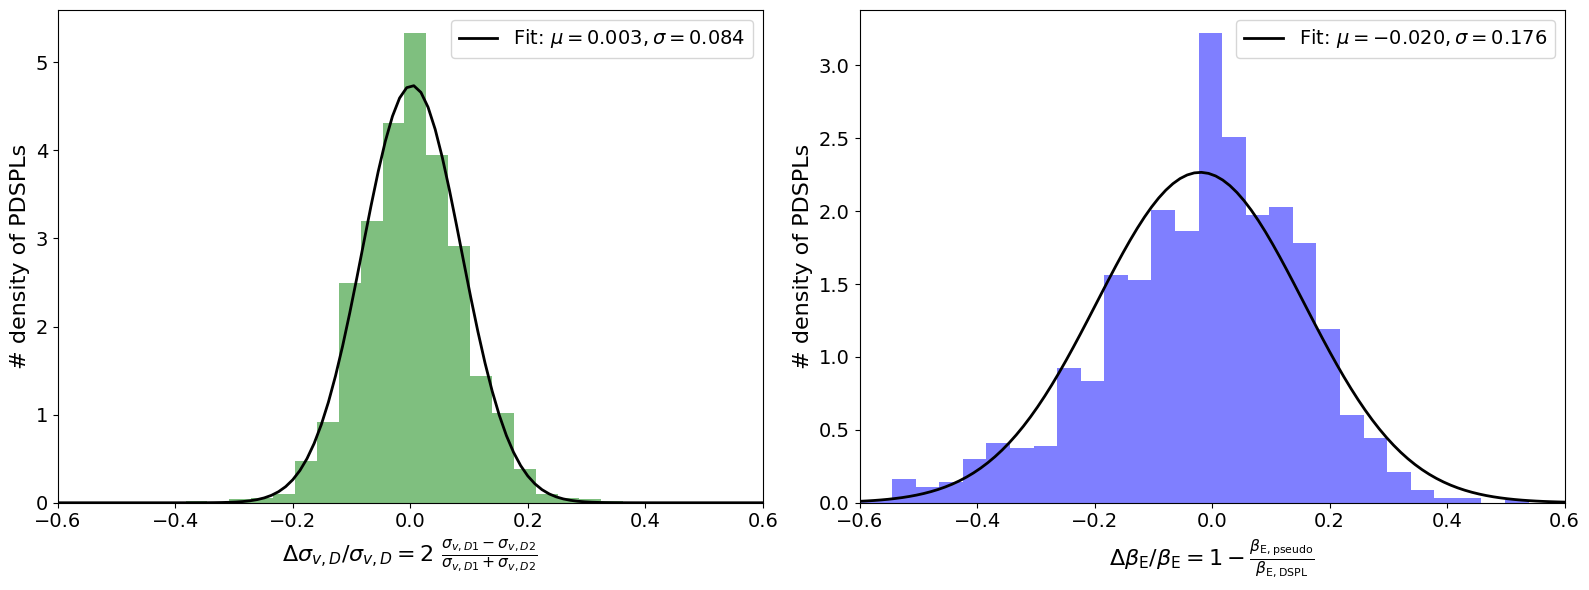

In [108]:
# histogram of the relative scatter in beta_E and sigma_v_D
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

masked_paired_table = individual_pair_data_table[
    np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) <= THRESHOLD_DELTA_Z
]

# First histogram: relative scatter in sigma_v_D
axs[0].hist(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2']),
    bins=20, color='green', alpha=0.5, density=True
)
axs[0].set_xlabel(r'$\Delta \sigma_{v,D} / \sigma_{v,D} = 2 \ \frac{\sigma_{v,D1} - \sigma_{v,D2}}{\sigma_{v,D1} + \sigma_{v,D2}}$', fontsize=16)
axs[0].set_ylabel('# density of PDSPLs', fontsize=16)
# axs[0].set_title('Histogram of Relative Scatter in $\\sigma_{v,D}$', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
from scipy.stats import norm
mu, std = norm.fit(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2'])
)
x = np.linspace(-0.6, 0.6, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2, label=f'Fit: $\\mu={mu:.3f}, \\sigma={std:.3f}$')
axs[0].legend(fontsize=14)

# Second histogram: relative scatter in beta_E
axs[1].hist(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'], bins=40, 
            color='blue', alpha=0.5, density=True)
axs[1].set_xlabel(r'$\Delta \beta_{\rm E} / \beta_{\rm E} = 1 - \frac{\beta_{\rm E,pseudo}}{\beta_{\rm E,DSPL}}$', fontsize=16)
axs[1].set_ylabel('# density of PDSPLs', fontsize=16)
# axs[1].set_title('Histogram of Relative Scatter in $\\beta_E$', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
mu_beta, std_beta = norm.fit(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'])
x_beta = np.linspace(-0.6, 0.6, 100)
p_beta = norm.pdf(x_beta, mu_beta, std_beta)
axs[1].plot(x_beta, p_beta, 'k', linewidth=2, label=f'Fit: $\\mu={mu_beta:.3f}, \\sigma={std_beta:.3f}$')
axs[1].legend(fontsize=14)

fig.tight_layout()

fig.savefig(f"../figures/slsim_hists_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)